#### Vicky van der Wagt

# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [573]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [615]:
# Add any additional import statements you need here

#nltk.download('punkt')
from nltk.tokenize import word_tokenize


In [616]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/vicky/Documents/GitHub/ADS509-Assignment2.2/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [618]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    #print length of set of tokens (sets can't have duplicates)
    num_unique_tokens = len(set(tokens))
    #ratio of unique tokens to the total number of tokens
    #added if statement just incase num_tokens is 0 which would result in error
    lexical_diversity = num_unique_tokens / num_tokens if len(tokens) > 0 else 0
    #for each token, count the length (# of characters)
    num_characters = sum(len(token) for token in tokens)

    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [619]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


Q: Why is it beneficial to use assertion statements in your code? 

A: It is beneficial to use assertions in code because they can check that the code is working as expected. In the case of the funciton above, the correct values were known beforehand and the assert statement verified that we got the values we expected, and that the function was working as expected.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [642]:
#read in the lyrics data
lyrics_path = os.path.join(data_location, lyrics_folder)

#initialize dictionary
lyrics_dict = {}

#for every artist (folder) in lyrics path...
for artist in os.listdir(lyrics_path):
    #find the artist path
    artist_path = os.path.join(lyrics_path, artist)
    if os.path.isdir(artist_path):  
        #initialize dictionary to hold songs
        artist_songs = {}  
        #for each song in artist_path
        for song_file in os.listdir(artist_path):
            #if a .txt file...
            if song_file.endswith('.txt'):
                # extract song title(after 1st  _ delimiter)
                song_title = song_file.split("_", 1)[1].split(".")[0]
                song_path = os.path.join(artist_path, song_file)
                with open(song_path, 'r', encoding='utf-8') as file:
                    #read the file
                    song_lyrics = file.read()  
                    #artist_song and song_lyrics - key value pair
                    artist_songs[song_title] = song_lyrics  
        #nested dictionary. artist is key to the artist_songs dictionary            
        lyrics_dict[artist] = artist_songs  # Add artist as a key to the dictionary with the nested dictionary of song titles and lyrics


In [651]:
# Read in the twitter data
twitter_path = os.path.join(data_location,twitter_folder)

#initialize dictionary
description_dict = {}

#for subfolder containing the word data in the twitter path
for data_file in os.listdir(twitter_path):
    #filter for files with data in the name
    if "data" in data_file:
        #extract artist name as text in the file name before the underscore
        artist_name = data_file.split("_")[0]
        #make empty list for descriptions
        description_strings = []
        # read file
        with open(os.path.join(twitter_path, data_file), 'r') as file:
            # skip header line because it does not contain descriptions
            next(file)
            # for each line in the files...
            for line in file:
                # split text file into columns, tab delimited
                columns = line.strip().split('\t') 
                # append description to list
                #needed to specify column length, because blank columns were creating issues
                if len(columns) >= 7:
                    description_strings.append(columns[6])  # Assuming the description column is the seventh column
        # add artist name and descriptions to dictionary
        description_dict[artist_name] = description_strings


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [623]:
punctuation = set(punctuation) # speeds up comparison

In [624]:
#generate data cleaning function
def data_cleaning(data):
    '''This function removes punctuation, folds characters to lowercase,
        splits on whitespace, and removes stopwords. Input is a dictionary.'''
    for key, value in data.items():
        cleaned_values = []
        for text in value:
            # remove punctuation characters
            # if character is not in punctuation, fold lowercase and string together
            text = ''.join(char.lower() for char in text if char not in punctuation)
            # split on whitespace (.split() splits on whitespace as default)
            tokens = text.split()
            # remove stop_words (generally common words) from data
            tokens = [token for token in tokens if token not in sw]
            # Join the cleaned tokens back into a string
            cleaned_values.append(' '.join(tokens))
        # Update the value of the original dictionary with the cleaned values
        data[key] = cleaned_values
    return data


In [626]:
# create your clean twitter data here
cleaned_description_dict = data_cleaning(description_dict)

In [625]:
# create your clean lyric data here
cleaned_lyrics_dict = data_cleaning(lyrics_dict)

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [627]:
#first, generate function to tokenize and filter data 
def tokenize_artist_filter(text, artist):
    '''This function tokenizes the text in a text dictionary. 
    Additionally, it takes artist filters as input so that only
    text associated with a specific artist key is tokenized. '''
    if artist in text:
        combined_text = ' '.join([str(value) for key, value in text.items() if key == artist])
        text_tokens = word_tokenize(combined_text)
        return text_tokens
    else:
        print(f"Artist '{artist}' not found in the dictionary.")
        return []


In [628]:
lyric_tokens_cher = tokenize_artist_filter(cleaned_lyrics_dict, 'cher')
lyric_tokens_robyn = tokenize_artist_filter(cleaned_lyrics_dict, 'robyn')
description_tokens_cher = tokenize_artist_filter(cleaned_description_dict, 'cher')
description_tokens_robyn = tokenize_artist_filter(cleaned_description_dict, 'robynkonichiwa')

In [629]:
# calls to descriptive_stats here
print("Cher lyrics - descriptive statistics:\n")
lyrics_descriptive_stats = descriptive_stats(lyric_tokens_cher)

print("\n\nRobyn lyrics - descriptive statistics:\n")
lyrics_descriptive_stats = descriptive_stats(lyric_tokens_robyn)

print("\nCher twitter profile descriptions - descriptive statistics:\n")
lyrics_descriptive_stats = descriptive_stats(description_tokens_cher)

print("\nRobyn twitter profile descriptions - descriptive statistics:\n")
lyrics_descriptive_stats = descriptive_stats(description_tokens_robyn)

Cher lyrics - descriptive statistics:

There are 948 tokens in the data.
There are 320 unique tokens in the data.
There are 5629 characters in the data.
The lexical diversity is 0.338 in the data.


Robyn lyrics - descriptive statistics:

There are 312 tokens in the data.
There are 108 unique tokens in the data.
There are 1680 characters in the data.
The lexical diversity is 0.346 in the data.

Cher twitter profile descriptions - descriptive statistics:

There are 19940092 tokens in the data.
There are 1600885 unique tokens in the data.
There are 99570808 characters in the data.
The lexical diversity is 0.080 in the data.

Robyn twitter profile descriptions - descriptive statistics:

There are 1893275 tokens in the data.
There are 273748 unique tokens in the data.
There are 9754444 characters in the data.
The lexical diversity is 0.145 in the data.


Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: If stopwords were left in the data, I believe that the top 5 words would be composed of stopwords. Stopwords are super common and frequent as they are critical for grammar and sentence structure. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I have never listened to Robyn, so I didn't have prior beliefs between the two artists. However, I was surpised to see that Cher's lexical diversity was only 10.6%. I imagined a higher number, perhaps around 20 or 30% especially because we excluded stopwords. Therefore, the lexical diversity rate did not conform to my prior beliefs. 



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [630]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁


What are the ten most common emojis by artist in the twitter descriptions? 

In [656]:
# Your code here

#generate emoji function 
def top_x_emojis(text):
    '''this '''
    #can change value of x is desired. the # of top emojis to be counted
    x=10
    emojis = [char for char in text if emoji.is_emoji(char)]
    emoji_counts = Counter(emojis)
    # Get the top 10 emojis with the highest counts
    top_10_emojis = emoji_counts.most_common(10)
    return top_10_emojis

cher_top_10_emojis = top_x_emojis(description_tokens_cher)
print("Most common emojis of twitter users following Cher: \n")
print([emoji for emoji, _ in cher_top_10_emojis])

robyn_top_10_emojis = top_x_emojis(description_tokens_robyn)
print("\n\n Most common emojis of twitter users following Robyn: \n")
print([emoji for emoji, _ in robyn_top_10_emojis])

Most common emojis of twitter users following Cher: 

['❤️', '♥', '❤', '✨', '🌈', '💙', '🇺🇸', '💜', '💕', '🌊']


 Most common emojis of twitter users following Robyn: 

['♥', '❤️', '✨', '❤', '🌈', '🎶', '💜', '🎧', '🖤', '💙']


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 

In [654]:
#important to note that the '#' characters were removed during our initial data cleaning.

#use unclean: description_dict
#tokenize description_dict cher

descriptions_combined_cher_unclean= ' '.join([str(value) for key, value in description_dict.items() if key == 'cher'])
descriptions_combined_robyn_unclean= ' '.join([str(value) for key, value in description_dict.items() if key == 'robynkonichiwa'])

In [655]:
#Your code here

def top_x_hashtags(text):
    x = 10
    text = text.lower()
    text_without_punctuation = ''.join(char if char == '#' or char not in punctuation else ' ' for char in text)
    tokens = text_without_punctuation.split()
    hashtags = [token for token in tokens if token.startswith('#')]
    #count number of hashtags
    hashtag_counts = Counter(hashtags)
    # get the top x number of hashtags
    top_x_hashtags = hashtag_counts.most_common(x)
    top_hashtags = [hashtag for hashtag, _ in top_x_hashtags]
    return top_hashtags

#extract top 10 hashtags for each artist
top_10_hashtags_cher = top_x_hashtags(descriptions_combined_cher_unclean)
top_10_hashtags_robyn = top_x_hashtags(descriptions_combined_robyn_unclean)

#print results
print("Most common hashtags of artists following Cher: \n")
print(top_10_hashtags_cher)

print("\n\nMost common hashtags of artists following Robyn: \n")
print(top_10_hashtags_robyn)

Most common hashtags of artists following Cher: 

['#resist', '#blm', '#blacklivesmatter', '#theresistance', '#fbr', '#resistance', '#', '#1', '#voteblue', '#lgbtq']


Most common hashtags of artists following Robyn: 

['#blacklivesmatter', '#blm', '#music', '#1', '#', '#teamfollowback', '#edm', '#lgbtq', '#resist', '#art']


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [645]:
# Your code here

#function to extract titles
def extract_song_titles(lyrics_dict):
    '''Extracts the title of each song from the lyrics dictionary.'''
    song_titles = {}
    for artist, songs in lyrics_dict.items():
        for song, lyrics in songs.items():
            # if lyrics exist...
            if lyrics:
                # extract the title (all the text prior to line break)
                title = lyrics.split('\n')[0]
                # store title under artist key in song dictionary
                song_titles.setdefault(artist, []).append(title)
    return song_titles

#extract song titles
titles = extract_song_titles(lyrics_dict)
#clean the song titles
titles_cleaned = data_cleaning(titles)

#combine, clean, tokenize all cher and robyn songs (filtered seperately)
combined_titles_cher = ' '.join([str(value) for key, value in titles_cleaned.items() if key == 'cher'])
combined_titles_robyn = ' '.join([str(value) for key, value in titles_cleaned.items() if key == 'robyn'])

cleaned_combined_titles_cher = ''.join([char for char in combined_titles_cher if char not in punctuation])
cleaned_combined_titles_cher_tokenized = word_tokenize(cleaned_combined_titles_cher)

cleaned_combined_titles_robyn = ''.join([char for char in combined_titles_robyn if char not in punctuation])
cleaned_combined_titles_robyn_tokenized = word_tokenize(cleaned_combined_titles_robyn)

In [646]:
def top_5_words(tokenized_text):
    '''This function extracts the most common 5 words'''
    #count number of each word
    word_counts = Counter(tokenized_text)
    #get and return the top 5 words
    top_5 = [word for word, _ in word_counts.most_common(5)]
    return top_5

In [647]:
# get the top 5 words from both cher and robyn
title_cher_top_5_words = top_5_words(cleaned_combined_titles_cher_tokenized)
title_robyn_top_5_words = top_5_words(cleaned_combined_titles_robyn_tokenized)

#print the results
print("Five most common words in Cher song titles:\n")
print(title_cher_top_5_words)

print("\n\nFive most common words in Robyn song titles:\n")
print(title_robyn_top_5_words)

Five most common words in Cher song titles:

['love', 'man', 'song', 'dont', 'come']


Five most common words in Robyn song titles:

['love', 'dont', 'u', 'hang', 'tell']


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

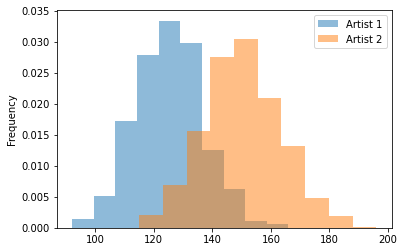

In [648]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: This regular expression matches on one or more instances of any whitespace character. Whitespace characters include spaces, tabs, as well as new lines. 


In [649]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyrics):
    '''this function splits/collapses lyrics on whitespace'''
    lines = lyrics.split('\n')
    #exclude the title
    lyrics_without_title = '\n'.join(lines[1:])
    # Tokenize the lyrics without the title
    tokens = word_tokenize(lyrics_without_title)
    return tokens

def count_tokens(dictionary):
    ''' this function counts the number of tokens (song lyrics) in dictionary'''
    token_counts = []
    for artist, songs in dictionary.items():
        for song, lyrics in songs.items():
            # tokenize lyrics
            tokens = tokenize_lyrics(lyrics)
            # store the number of tokens (length)
            length = len(tokens)
            # append artist name and associated token count to list
            token_counts.append({'artist': artist, 'length': length})
    # save dictionary list as dataframe
    df = pd.DataFrame(token_counts)
    return df

song_lengths = count_tokens(lyrics_dict)


artist
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

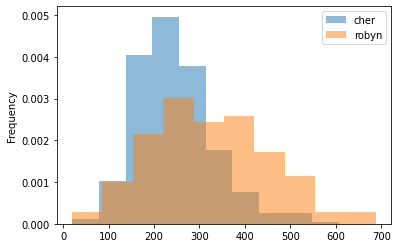

In [650]:
# Your lyric length comparison chart here. 

\
song_lengths.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)